## Graph Coloring

We are given an undirected graph $G=(V,E)$ where $V$ is the set of vertices and $E$ is the set of edges. Given $n$ colors, is it possible to color the graph such that no two adjacent vertices have the same color. It is a NP-Complete problem as it's a generalization of the NP-Hard problem, how many colors are needed to color the graph in the respective manner. 

We use networkx and matplotlib to create and display the graph.

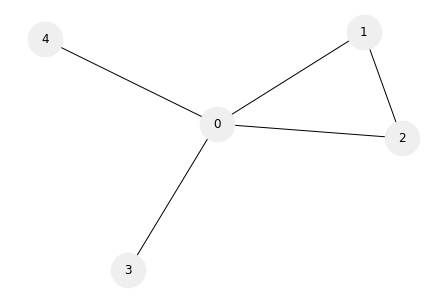

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

n = 5
m = 3
G = nx.Graph()
G.add_nodes_from(nx.path_graph(n))
G.add_edges_from([(0,1), (0,2), (0,3),(0,4),(1,2)])
nx.draw(G, **options)

$n$ is the number of vertices and $i$ is the number of colors.
We take a binary variable $x_{v,i}$ for each element in a vertex-color matrix. Thus the total number of qubits that will be used are $n*i$.

We have two main constraints:
1. Every vertex should be represented by only one color.

$$ C_1 = A\sum_{v} (1 - \sum_{i=1}^{m} x_{v,i})^2 $$

2. Adjacent vertices should have different colours.

$$ C_2 = \sum_{(uv) \in E}^{n} \sum_{i=1}^{m} x_{u,i}*x_{v,i} $$



Let us first create an expression for hamiltonian using blueqat. The QUBO model and the ising model being isomorphic, we can make use of the equation $x_i = \frac{1-z_i}{2}$ where $z_i \in \{-1,1\}$ and $x_i$ being $\{0,1\}$.

The ising form of the above QUBO Hamiltonian will be : 

$$ C = A\sum_{v} (1 - \sum_{i=1}^{m} \frac{1-z_{v,i}}{2})^2 + A\sum_{(uv) \in E}^{n} \sum_{i=1}^{m} \frac{1-z_{u,i}}{2}*\frac{1-z_{v,i}}{2}$$

The eigenvalues of a Z Pauli operator are 1 and -1, thus we can make use of the diagonal Z operator in writing the ising Hamiltonian of the above cost function.

The blueqat code for creating the ising Hamiltonian is :

In [17]:
from blueqat import vqe
from blueqat.pauli import *
import numpy as np

a = np.zeros((n,n), dtype=int)

for k in G.edges:
    a[k[0]][k[1]] = 1

b = np.zeros((n,m), dtype=int)

my_dict = {}




num = 0
for v in range(n):
    for i in range(m):
        b[v][i] = num
        my_dict[num]=[str(v),i]
        num+=1
        
        


h_1= 0.0
const_h = 0.0
for v in range (n):
    for i in range(m):
        const_h = const_h + (I - Z(b[v,i]))/2
        
    h_1 = h_1 + (I - const_h)**2
    const_h = 0.0
        
h_2 = 0.0    
for u in range(n):
    for v in range(n):
        for i in range(m):
            if(a[u,v]==1):
                h_2 = h_2 + 1/4 * (I-Z(b[u,i]))*(I-Z(b[v,i]))
                
h = h_1 + h_2
                
    


In [18]:
step = 2

result = vqe.Vqe(vqe.QaoaAnsatz(h, step)).run()
print(result.most_common(4))

(((0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0), 0.0020697085467843573), ((0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0), 0.0020697085467843573), ((0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1), 0.0020697085467843573), ((0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0), 0.0020697085467843565))


In [19]:
for i in range(n*m):
    if(result.most_common(4)[0][0][i]==1):
        print(my_dict[i])

['0', 1]
['1', 0]
['2', 2]
['3', 2]
['4', 0]
